!pip3 list
#Import Libraries 

In [24]:
# Data analysis 
import pandas as pd
import numpy as np 

# Data plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 16})

import seaborn as sn
from wordcloud import WordCloud

# Text analysis
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import emoji
import emot
import contractions
import string
import nltk
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense,LSTM,Dropout,Conv1D,MaxPooling1D,Flatten,BatchNormalization,Bidirectional,Lambda,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras import models, layers, optimizers
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.models import load_model

# Save model
import pickle

import time

# Data Loading

In [3]:
pd.set_option('max_colwidth', 150)

In [2]:
reviews = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/train.csv')
reviews

,Review,Label
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2
...,...,...
3599995,Don't do it!!: The high chair looks great when...,1
3599996,"Looks nice, low functionality: I have used thi...",1
3599997,"compact, but hard to clean: We have a small ho...",1
3599998,what is it saying?: not sure what this book is...,1


In [4]:
# Check if null values exist
reviews.isnull().value_counts()

Review  Label
False   False    3600000
dtype: int64

In [5]:
# Number of positive and negative reviews
reviews['Label'].value_counts()

2    1800000
1    1800000
Name: Label, dtype: int64

In [6]:
# Choose a random subset from the dataset with equal number of 
# positive and negative tweets
subset = 250000
pos_subset = reviews[reviews['Label'] == 2].sample(subset, random_state = 43)
neg_subset = reviews[reviews['Label'] == 1].sample(subset, random_state = 43)

modified_data = pd.concat([pos_subset, neg_subset])
modified_data = modified_data.reset_index(drop=True)

In [7]:
# Positive label = 1, negative label = 0
modified_data['Label'] = modified_data['Label'].apply(lambda x: 1 if x == 2 else 0)

In [8]:
modified_data

,Review,Label
0,"Good novel about gay youth: There are two books in gay romance fiction that I consider to be the Holy Grails of that genre: E.M. Forster's ""Mauric...",1
1,"Tudors Season I: This series is ""Awesome!"" It is addicting. Once you start, there's no way you can stop watching it. I have seen all seasons twice...",1
2,Ah the memories.: What can be said about Rocko's Modern Life? It was a bizarre look at life during the 90's (when cartoons were good) but it's tim...,1
3,Cancer is not a Disese by Andreas Moritz: A very refreshing new look at the subject of cancer. This book provides a very clear understanding on wh...,1
4,better late than never: I more or less stumbled onto this novel after the fact and I really enjoyed the fantastical tale told. I'd like to read so...,1
...,...,...
499995,too expensive: nearly 5 US$ for 2 pieces of hanuta?That is more than 100 % more as u pay in the supermarket!\n,0
499996,Disappointing: Starts out whimsical and ends up self conscious and dull. Found myself skimming at the end to get through it. The subplot about exp...,0
499997,"lots of errors!!!: i never write reviews, but i was so annoyed studying with this book that i just had to. there is very little explanation for wr...",0
499998,"CD not working: I had bought this Cd as a Christmas gift for my son who plays the oboe. By the time Christmas arrived and he opened the Cd, a coup...",0


# Data Preprocessing

In [9]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "1st" : "first", 
    "2nd" : "second", 
    "3rd" : "third",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "canx" : "cancel",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dnt" : "don't",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "emerg" : "emergency",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "haha" : "laugh", 
    "hahaha" : "laugh", 
    "hehe" : "laugh", 
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrs" : "hour",
    "hrh" : "his royal highness",    
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pls" : "please",
    "plz" : "please",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rite" : "right",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sry" : "sorry",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thank" : "thank",
    "thanks" : "thank",
    "thks" : "thank",
    "tho" : "though",
    "thx" : "thank",
    "tia" : "thanks in advance",
    "til" : "until",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "us" : "united states",
    "usa" : "united states",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "ya" : "you",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# This abbreviation list is by @nmaguette from Kaggle

In [10]:
def expand_abbreviation(text):
    """ This function takes an abbreviated string
        and returns the expanded version with whitespace 
        replaced by underscore """
    
    expanded_abbr = ''
    expanded_text = ''
    for word in text:
        expanded_abbr = word
        if word in abbreviations: 
            expanded_abbr = abbreviations[word]
            expanded_abbr = expanded_abbr.replace(' ', '_')          
        
        expanded_text = expanded_text + expanded_abbr + " "
    
    return expanded_text

In [11]:
emot_obj = emot.core.emot()  

In [12]:
def emoj_emot_to_text(text):
    """ This function converts emojis and emoticons to corresponding text """
    
    # Emoticons  
    emoticons_list = emot_obj.emoticons(text)['mean']
    for emoticon in emoticons_list: 
        emoticon = emoticon.replace(', ', ' ')
        emoticon = emoticon.replace(' ', '_')
        text = text + emoticon + " "    
    
    # Emojis
    text = emoji.demojize(text) 
    text = re.sub(':', '', text)
    return text

In [13]:
stop_words = list(STOP_WORDS)

# Exclude from stop words list the following negative words
stop_words.remove('not')
stop_words.remove('never')
stop_words.remove('none')
stop_words.remove('noone')
stop_words.remove('neither')
stop_words.remove('cannot')

In [14]:
def remove_trivial_words(text):  
    """ This function Removes stopwords and words with length of one character or two """
    
    temp = ""
    for word in text.split():
        if  word not in stop_words:
            if len(word) != 1 and len(word) != 2:
                temp += word + " "
    return temp

In [103]:
# Stemming
snowballStemmer = SnowballStemmer(language='english') 

# Measure progress
progress = 0

def preprocess_texts(text, texts_total_len): 
    
    #     Preprocess texts
    text = text.lower() # Convert to lower case
    text = contractions.fix(text) # Remove contractions
    
    #     Remove insignificant characters using regex
    text = re.sub('\S+@\S+.\S+', '', text) # Remove emails
    text = re.sub('@[\S]+', '', text) # Remove mentions starting with @       
    text = re.sub('(http|https):\/\/[\S]*', '', text) # Remove links starting with http or https
    text = re.sub('#+\S*|\.+', '', text) # Remove Hashtags and dots
    text = re.sub(r'(.)\1{2,}', r'\1', text) # Remove characters repetition
    text = re.sub(r'&[\S]+;', '', text) # Remove html tags, such as &amp;  
    text = re.split('(\W+)', text) # Insert a space between characters and punctuations
    
    # Expand abbreviations
    text = expand_abbreviation(text)
    
    # Emojis and Emoticons
    text = emoj_emot_to_text(text)      
    
    text = re.sub('\W', ' ', text)  # Remove remaining punctuations  
    text = re.sub('\d', '', text)  # Remove Numbers    
   
    # Remove trivial words
    text = remove_trivial_words(text)
    
    # Stemming    
    stemmed_token_list = [] 
    for token in text.split(): 
        stemmed_token_list.append(snowballStemmer.stem(token))    
    
    # Progress
    global progress 
    progress += 1
    percent = 100 * (progress / float(texts_total_len))
    if (percent % 10) == 0:
        print(f'====== {percent} ======')        
        if percent == 100:
            # Reset progress
            progress = 0    
    
    return stemmed_token_list #Return processed text as a list

In [16]:
# Start timer
start = time.perf_counter()
modified_data['Tokens'] = modified_data['Review'].apply(preprocess_texts, texts_total_len = modified_data.shape[0])
end = time.perf_counter()
print(f'Preprocessing time: {end - start} s')

====== 10.0 ======
====== 20.0 ======
====== 30.0 ======
====== 40.0 ======
====== 50.0 ======
====== 60.0 ======
====== 70.0 ======
====== 80.0 ======
====== 90.0 ======
====== 100.0 ======
Preprocessing time: 634.7273753849995 s


In [61]:
# Convert token lists to string 
def convert_list_str(tokens):
    return ' '.join(tokens)

modified_data['String_tokens'] = modified_data['Tokens'].apply(convert_list_str)

In [18]:
modified_data

,Review,Label,Tokens,String_tokens
0,"Good novel about gay youth: There are two books in gay romance fiction that I consider to be the Holy Grails of that genre: E.M. Forster's ""Mauric...",1,"[good, novel, gay, youth, book, gay, romanc, fiction, consid, holi, grail, genr, forster, mauric, patricia, nell, warren, runner, gay, romanc, nov...",good novel gay youth book gay romanc fiction consid holi grail genr forster mauric patricia nell warren runner gay romanc novel come stori not wei...
1,"Tudors Season I: This series is ""Awesome!"" It is addicting. Once you start, there's no way you can stop watching it. I have seen all seasons twice...",1,"[tudor, season, seri, awesom, addict, start, way, stop, watch, seen, season, twice, start, watch, season, love]",tudor season seri awesom addict start way stop watch seen season twice start watch season love
2,Ah the memories.: What can be said about Rocko's Modern Life? It was a bizarre look at life during the 90's (when cartoons were good) but it's tim...,1,"[memori, said, rocko, modern, life, bizarr, look, life, cartoon, good, timeless, adult, subtl, adult, joke]",memori said rocko modern life bizarr look life cartoon good timeless adult subtl adult joke
3,Cancer is not a Disese by Andreas Moritz: A very refreshing new look at the subject of cancer. This book provides a very clear understanding on wh...,1,"[cancer, not, dises, andrea, moritz, refresh, new, look, subject, cancer, book, provid, clear, understand, decad, war, cancer, convent, treatment,...",cancer not dises andrea moritz refresh new look subject cancer book provid clear understand decad war cancer convent treatment ahead find solution...
4,better late than never: I more or less stumbled onto this novel after the fact and I really enjoyed the fantastical tale told. I'd like to read so...,1,"[better, late, never, stumbl, novel, fact, enjoy, fantast, tale, told, like, read, novel, seri]",better late never stumbl novel fact enjoy fantast tale told like read novel seri
...,...,...,...,...
499995,too expensive: nearly 5 US$ for 2 pieces of hanuta?That is more than 100 % more as u pay in the supermarket!\n,0,"[expens, near, united_st, piec, hanuta, pay, supermarket]",expens near united_st piec hanuta pay supermarket
499996,Disappointing: Starts out whimsical and ends up self conscious and dull. Found myself skimming at the end to get through it. The subplot about exp...,0,"[disappoint, start, whimsic, end, self, conscious, dull, found, skim, end, subplot, expel, jew, place, uncomfort, disappoint, read, star, review]",disappoint start whimsic end self conscious dull found skim end subplot expel jew place uncomfort disappoint read star review
499997,"lots of errors!!!: i never write reviews, but i was so annoyed studying with this book that i just had to. there is very little explanation for wr...",0,"[lot, error, never, write, review, annoy, studi, book, littl, explan, wrong, answer, practic, section, practic, problem, subject, review, found, m...",lot error never write review annoy studi book littl explan wrong answer practic section practic problem subject review found mistak question answe...
499998,"CD not working: I had bought this Cd as a Christmas gift for my son who plays the oboe. By the time Christmas arrived and he opened the Cd, a coup...",0,"[not, work, bought, christma, gift, son, play, obo, time, christma, arriv, open, coupl, month, pass, great, disappoint, found, not, work, tri, cle...",not work bought christma gift son play obo time christma arriv open coupl month pass great disappoint found not work tri clean result unfortun tim...


# Analyze Data After Preprocessing 

In [102]:
# Count the number of tokens in the dataset after processing
num_unique_tokens = 0
num_of_total_tokens = 0
num_pos_tokens = 0
num_neg_tokens = 0
pos_tokens = []
neg_tokens = []
rows = modified_data.shape[0]

for i in range(rows):
    if modified_data['Label'][i] == 0:
        for token in modified_data['Tokens'][i]:
            neg_tokens.append(token)    
    else:
        for token in modified_data['Tokens'][i]:
            pos_tokens.append(token)     

num_pos_tokens = len(pos_tokens)
num_neg_tokens = len(neg_tokens)
num_of_total_tokens = num_pos_tokens + num_neg_tokens
num_unique_tokens = len(set(pos_tokens).union(neg_tokens))

print(f"""Number of tokens: {num_of_total_tokens}
Number of unique tokens: {num_unique_tokens}
Positive Tokens: {num_pos_tokens}
Negative Tokens: {num_neg_tokens}
Positive Unique Tokens: {len(set(pos_tokens))}
Negative Unique Tokens: {len(set(neg_tokens))}""")

Number of tokens: 17617873
Number of unique tokens: 336453
Positive Tokens: 8539391
Negative Tokens: 9078482
Positive Unique Tokens: 210961
Negative Unique Tokens: 203686


In [59]:
# Calculate words occurrences
def occurrences_of_words(data, reverse=True):
    freq_words_dic = {}
    rows = data.shape[0]
    
    for i in range(rows):
        for word in data['Tokens'][i]:
            if word in freq_words_dic:
                freq = freq_words_dic[word]
                freq_words_dic[word] = freq + 1
            else:
                freq_words_dic[word] = 1
    return sorted(freq_words_dic.items(), key=lambda x: x[1], reverse=reverse)

In [60]:
# Calculate words occurrences in negative reviews
neg_modified_data = modified_data[modified_data['Label'] == 0]
neg_modified_data = neg_modified_data.reset_index(drop=True)

neg_freq_words = occurrences_of_words(neg_modified_data)
neg_freq_words[:20]

[('not', 388905),
 ('book', 149051),
 ('like', 83551),
 ('time', 62328),
 ('work', 60903),
 ('good', 60383),
 ('read', 58241),
 ('movi', 52031),
 ('buy', 49985),
 ('product', 46092),
 ('look', 38912),
 ('money', 37862),
 ('tri', 36584),
 ('disappoint', 35828),
 ('use', 35775),
 ('want', 34517),
 ('great', 33945),
 ('bad', 33928),
 ('better', 32551),
 ('bought', 30575)]

In [66]:
# Calculate words occurances in positive reviews
pos_modified_data = modified_data[modified_data['Label'] == 1]
pos_modified_data = pos_modified_data.reset_index(drop=True)

pos_freq_words = occurrences_of_words(pos_modified_data)
pos_freq_words[:20]

[('not', 183281),
 ('book', 160417),
 ('great', 115630),
 ('good', 82677),
 ('like', 78538),
 ('read', 75310),
 ('love', 73562),
 ('time', 55311),
 ('work', 47085),
 ('movi', 45027),
 ('best', 44371),
 ('album', 36631),
 ('year', 34544),
 ('stori', 34381),
 ('use', 33190),
 ('song', 32085),
 ('look', 31464),
 ('recommend', 30224),
 ('music', 30050),
 ('want', 29199)]

In [67]:
def plot_freq_words(freq_words_list, label, color):
    """ Plot a bar chart with the most frequent words """

    freq_words  = [f_item[0] for f_item in freq_words_list]
    occurrences = [s_item[1] for s_item in freq_words_list]    
    
    # X ticks position
    x_pos = [x*2 for x in range(20)]
    
    plt.figure(figsize=(12, 7))
    plt.bar(x_pos, occurrences, align='center', width=1.5, alpha=0.8, color=color, label=label)
    plt.xlabel('Most Frequent Words')
    plt.ylabel('Number of occurances')
    plt.legend()
    plt.xticks(x_pos, freq_words, rotation='vertical')
    plt.show()

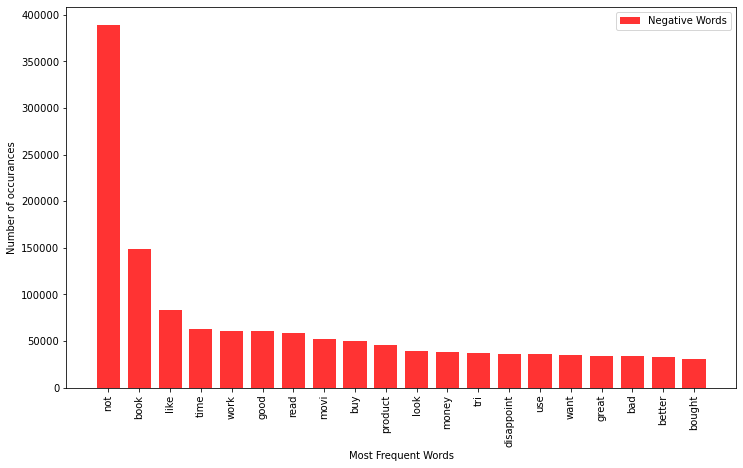

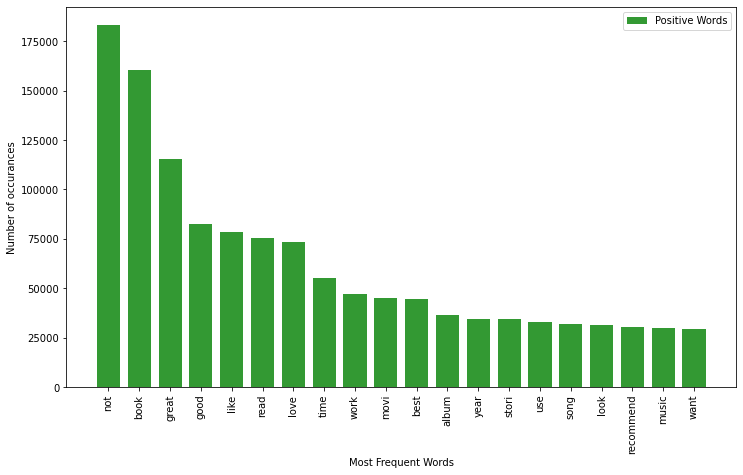

In [68]:
# Plot a bar chart for neg words
plot_freq_words(neg_freq_words[:20], 'Negative Words', 'red')

# Plot a bar chart for pos words
plot_freq_words(pos_freq_words[:20], 'Positive Words', 'green')

In [69]:
# Display a word cloud
def plot_wordcloud(text, words):

    wc = WordCloud(width = 1920, height = 1080, background_color = 'black', max_words = words, colormap='Set2')
    wc.generate(text)    
    
    plt.figure(figsize=(10,10), facecolor="black")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

In [70]:
# Extract frequent words 
wc_neg_text = [word[0] for word in neg_freq_words]
wc_neg_text = ' '.join(wc_neg_text)

wc_pos_text = [word[0] for word in pos_freq_words]
wc_pos_text = ' '.join(wc_pos_text)

Negative Frequent Words: 


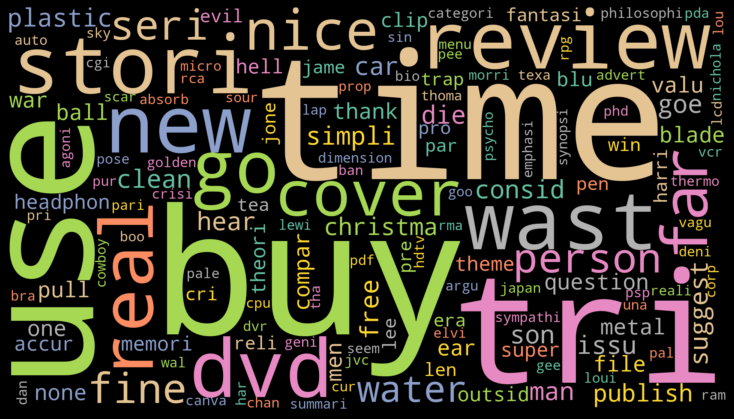


Positive Frequent Words: 


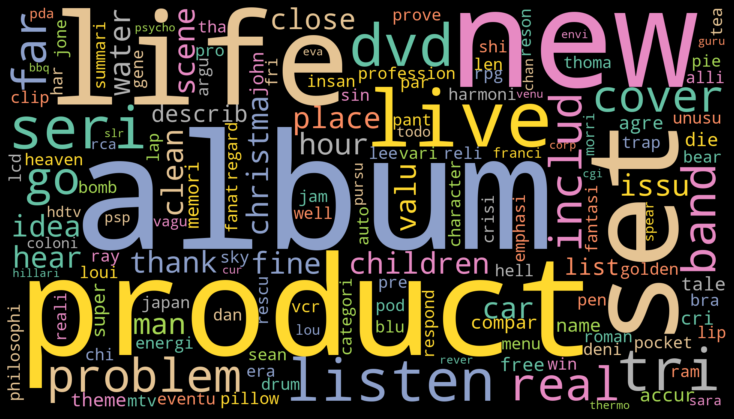

In [76]:
max_words = 150
print('Negative Frequent Words: ')
plot_wordcloud(wc_neg_text, max_words)

print('\nPositive Frequent Words: ')
plot_wordcloud(wc_pos_text, max_words)

# Model Training using RNN

In [19]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(modified_data['String_tokens'], modified_data['Label'], test_size=0.2, random_state=0)

In [20]:
# Limit words length
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

In [101]:
len(tokenizer.word_index)

287967

In [21]:
# Limit sequences length
max_length = 300

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen = max_length, truncating= 'post')

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen = max_length, truncating= 'post')

In [87]:
# Initializing RNN model
model = Sequential()

# Adding embedding layer 
model.add(Embedding(input_dim = vocab_size, output_dim = 100, input_length = max_length))

model.add(BatchNormalization())

# Adding LSTM layer
model.add(LSTM(10))

# Adding output layer
model.add(Dense(1,activation='sigmoid'))

# Compiling model
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [113]:
rnn_model = model.fit(X_train, y_train, batch_size=1024, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
391/391 [==============================] - 587s 2s/step - loss: 0.2950 - accuracy: 0.8770 - val_loss: 0.4807 - val_accuracy: 0.8281
Epoch 2/5
391/391 [==============================] - 736s 2s/step - loss: 0.2262 - accuracy: 0.9099 - val_loss: 0.2432 - val_accuracy: 0.9027
Epoch 3/5
391/391 [==============================] - 833s 2s/step - loss: 0.2034 - accuracy: 0.9196 - val_loss: 0.2385 - val_accuracy: 0.9047
Epoch 4/5
391/391 [==============================] - 340s 866ms/step - loss: 0.1866 - accuracy: 0.9275 - val_loss: 0.2412 - val_accuracy: 0.9045
Epoch 5/5
391/391 [==============================] - 294s 751ms/step - loss: 0.1725 - accuracy: 0.9338 - val_loss: 0.2491 - val_accuracy: 0.9034


# Save RNN model

In [ ]:
# model.save("/home/verpen/Downloads/Datasets/Models/SA_Amazon_Reviews_RNN.h5")

# Testing the model

In [25]:
rnn = load_model("/home/verpen/Downloads/Datasets/Models/SA_Amazon_Reviews_RNN.h5")

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     50108
           1       0.89      0.92      0.90     49892

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000

[[44620  5488]
 [ 4174 45718]]


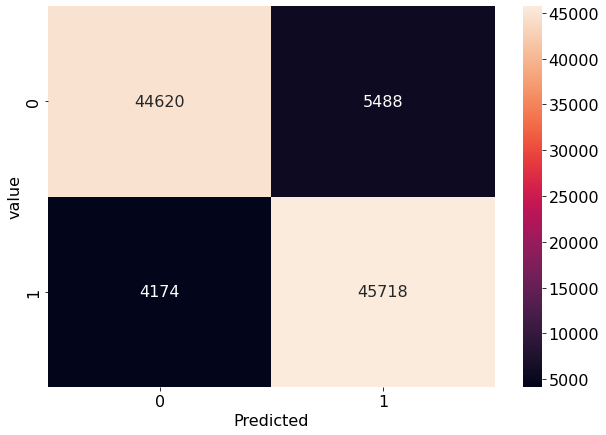

Unique: [0. 1.]		Counts: [48794 51206]


([<matplotlib.patches.Wedge at 0x7f13e8664580>,
 [Text(0.04166635168617436, 1.0992105872566749, 'Negative'),
  Text(-0.041666351686174496, -1.0992105872566749, 'Positive')],
 [Text(0.022727100919731468, 0.5995694112309136, '48.79%'),
  Text(-0.02272710091973154, -0.5995694112309136, '51.21%')])

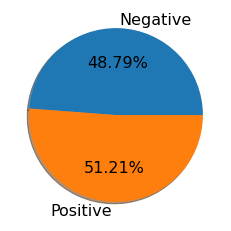

In [34]:
# Analyze RNN model 
y_pred = rnn.predict(X_test)
y_pred = y_pred.round()

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)
    
# Plot a heatmap
plt.figure(figsize= (10, 7))
sn.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('value')
plt.show()
    
# Plot a pie 
(unique, counts) = np.unique(y_pred, return_counts=True)
print(f'Unique: {unique}\t\tCounts: {counts}')
    
neg_texts_counts = counts[0]
pos_texts_counts = counts[1]
labels = ["Negative", "Positive"]
plt.pie(counts, labels=labels, shadow=True, autopct="%1.2f%%")

In [91]:
# Pipeline for processing and predicting new data
def pipeline(model, test_texts, test_labels, max_length = 300):
    
    # Preprocessing
    print("Processing texts....")
    start = time.perf_counter()
    processed_texts = test_texts.apply(preprocess_texts, texts_total_len = len(test_texts))
    string_texts = processed_texts.apply(convert_list_str)
    end = time.perf_counter()    
    print(f'Processing time: {end - start}')
    
    # Transforming processed texts to sequences
    test_sequences = tokenizer.texts_to_sequences(string_texts)
    X_test = pad_sequences(test_sequences, maxlen = max_length, truncating = 'post')
    
    # Predict
    print("Predicting....")
    predictions = model.predict(X_test)
    predictions = predictions.round()
    
    # Print a Classification report
    print(classification_report(test_labels, predictions))
    cm = confusion_matrix(test_labels, predictions, labels=[0, 1])
    print(cm)
    
    # Plot a heatmap
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()
    
    # Plot a pie 
    (unique, counts) = np.unique(predictions, return_counts=True)
    print(f'Unique: {unique}\t\tCounts: {counts}')
    
    neg_texts_counts = counts[0]
    pos_texts_counts = counts[1]
    labels = ["Negative", "Positive"]
    plt.pie(counts, labels=labels, shadow=True, autopct="%1.2f%%")

# Model testing with Amazon Reviews Dataset

In [74]:
# Another test
amazon_reviews = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/test.csv') # 400k reviews
amazon_reviews = amazon_reviews.sample(400_000)
amazon_reviews = amazon_reviews.reset_index(drop=True)
amazon_reviews['Label'] = amazon_reviews['Label'].apply(lambda x: 1 if x == 2 else 0)
amazon_reviews

,Review,Label
0,Good: The adapter is good easy to install. I had difficulty however configuring the WPA settings with my linksys wireless router and had to use WE...,1
1,"The Slamming of ""Real"": I am really surprised to see how many people referred to Belinda's ""Real"" album in their critique of this album. Real is a...",0
2,"I guess it's okay for a Lindsay movie...?: I liked Freaky Friday, but after that, she pulled a Courtney Love and screwed over her whole life.Ashle...",0
3,"integrity, honesty: I received the game in a short amount of time, the game does not work in my new console..I wrote the company I purchased it fr...",0
4,"Weak, senseless Lyrics, with Cheap sounding Audio....: Way below average band, that makes corny music. Arn't they all dead now anyway?? Or close t...",0
...,...,...
399995,Helped with shopping: A perfect tool to use when shopping. It helps with the fine print on products. It was a great stocking stuffer.\n,1
399996,"Beware!! Doesn't fit.: This air filter doesn't fit a 2009 Toyota Camry LE 4 Cylinder, despite Amazon and Fram saying that it does. It is much too ...",0
399997,"A good book: ""Singing in the Comeback Choir"" is the second book I have read by Bebe Moore Campbell. I like her style of writing and her stories. T...",1
399998,Intuit stepped over the line: I found their little spyware jewel when trying to debug a touchpad delay problem that mysteriously appeared the day ...,0


Processing texts....
====== 260.0 ======
====== 270.0 ======
====== 280.0 ======
====== 290.0 ======
====== 300.0 ======
====== 310.0 ======
====== 320.0 ======
====== 330.0 ======
Processing time: 436.75592845400024
Predicting....
12500/12500 [==============================] - 218s 17ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90    200000
           1       0.89      0.92      0.90    200000

    accuracy                           0.90    400000
   macro avg       0.90      0.90      0.90    400000
weighted avg       0.90      0.90      0.90    400000

[[178188  21812]
 [ 16959 183041]]


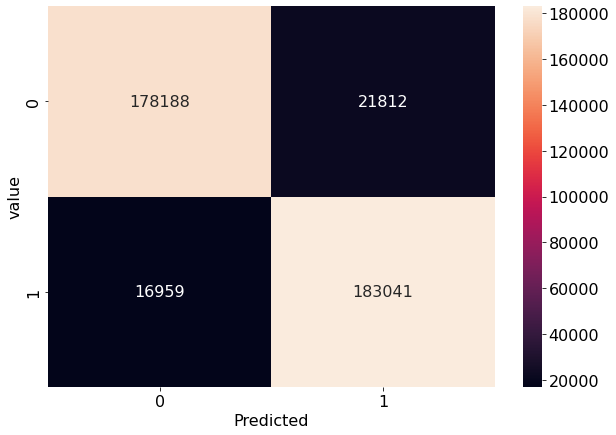

Unique: [0. 1.]		Counts: [195147 204853]


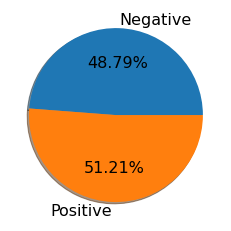

In [89]:
pipeline(rnn, amazon_reviews['Review'], amazon_reviews['Label'])

# Model testing with IMDb Movie Reviews Dataset

In [76]:
movie_reviews = pd.read_csv('/home/verpen/Downloads/Datasets/imdb/IMDb_Moview_Reviews.zip')
movie_reviews = movie_reviews.rename(columns={'review':'Review', 'sentiment': 'Label'})
movie_reviews['Label'] = movie_reviews['Label'].apply(lambda x: 1 if x == 'positive' else 0)
movie_reviews

,Review,Label
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...",1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. Thi...",1
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lot...",1
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a c...",0
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholi...",0
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that ...",0


Processing texts....
====== 10.0 ======
====== 20.0 ======
====== 30.0 ======
====== 40.0 ======
====== 50.0 ======
====== 60.0 ======
====== 70.0 ======
====== 80.0 ======
====== 90.0 ======
====== 100.0 ======
Processing time: 185.2804950030004
Predicting....
1563/1563 [==============================] - 25s 16ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     25000
           1       0.88      0.83      0.85     25000

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000

[[22040  2960]
 [ 4242 20758]]


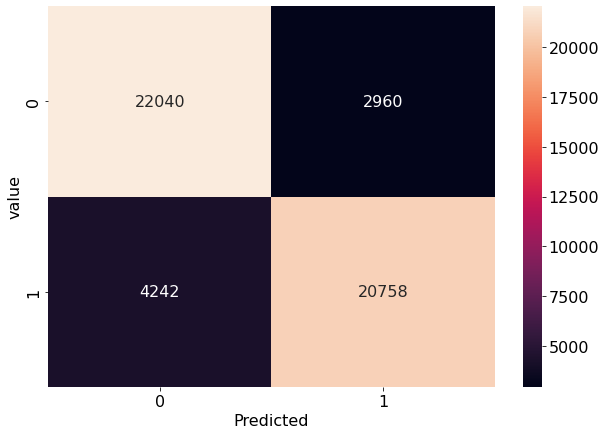

Unique: [0. 1.]		Counts: [26282 23718]


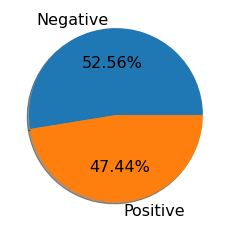

In [98]:
pipeline(rnn, movie_reviews['Review'], movie_reviews['Label'])

In [83]:
# https://github.com/anurag3290/IMDB-Sentiment-Analysis
pang_movies = pd.read_csv('/home/verpen/Downloads/Datasets/Pang/Movie_Reviews_2002/Movie_Reviews.csv')
pang_movies['Label'] = pang_movies['Label'].apply(lambda x: 1 if x == 2 else 0)
pang_movies

,Unnamed: 0,Review,Label
0,0,['the brady bunch movie is less a motion picture than a minor pop event . forget your reruns and forget your nick at nite ; this dead-on recreatio...,0
1,1,"['this movie tries to present itself as the sequel to jan de bont\'s debut as a director , 1994 surprise hit speed . but the only thing the two mo...",0
2,2,"['directed by brian helgeland . cast : mel gibson , gregg henry , maria bello , david paymer , william devane , lucy alexis liu , bill duke , debo...",0
3,3,"['director : brian depalma writer : david koepp ( story by brian depalma and david koepp ) starring : nicolas cage , gary sinise , carla gugino , ...",0
4,4,"['living out loud written and directed by richard lagravenese . photography , john bailey . editing , gregory & lynzee klingman . production desig...",0
...,...,...,...
1395,1395,"[""the sixth sense -a review by bill chambers ( 6sense@filmfreakcentral . net ) starring bruce willis , haley joel osment , toni collette , olivia...",1
1396,1396,"['i love japanese anime on the big screen . the gorgeous colors , the daunting cel animation detailing the smallest blades of grass , the complex ...",1
1397,1397,"['for just a couple of years now , a certain film director has been doing for action films what marisa tomei did earlier this year for the "" love ...",1
1398,1398,"['rushmore ( m ) . ( touchstone/beuna vista international ) director : wes anderson stars : jason schwartzman , olivia williams , bill murray , br...",1


Processing texts....
====== 10.0 ======
====== 20.0 ======
====== 30.0 ======
====== 40.0 ======
====== 50.0 ======
====== 60.0 ======
====== 70.0 ======
====== 80.0 ======
====== 90.0 ======
====== 100.0 ======
Processing time: 13.068636364001577
Predicting....
44/44 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       700
           1       0.81      0.73      0.77       700

    accuracy                           0.78      1400
   macro avg       0.78      0.78      0.78      1400
weighted avg       0.78      0.78      0.78      1400

[[582 118]
 [188 512]]


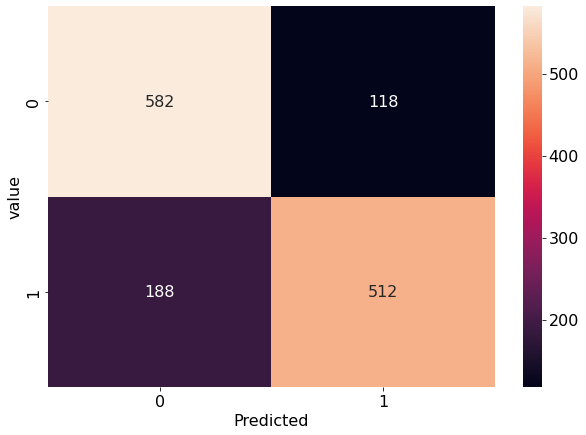

Unique: [0. 1.]		Counts: [770 630]


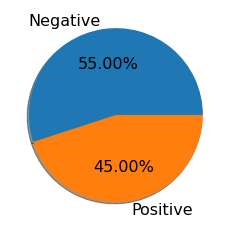

In [97]:
pipeline(rnn, pang_movies['Review'], pang_movies['Label'])